## 3. Linear Activation Function

$$
Z_L=\phi_L\left(B_L\cdot \tilde Z_{L-1} \right) \\
Z_L=\phi_L\left(B_L\cdot \phi_{L-1}\left(B_{L-1}\cdot \tilde Z_{L-2} \right) \right) \\
$$
Let $f_l: \mathbb R^{H_{l-1}}\rightarrow\mathbb R^{H_{l}}$ be the function that calculates the pre-activations: $Z_{l-1} \mapsto \tilde Z_l= B_l Z_{l-1}$ which is obviously a linear function. So the total function reads
$$
Z_L=\underbrace{\phi_L \circ f_L \circ \phi_{L-1} \circ f_{L-1} \circ \ldots \circ \phi_1 \circ f_1}_{=:\mathbf F} (Z_0)
$$
As the composition between two linear functions is still a linear function, $\mathbf F$ is also a linear function which can be written as a composition of two arbitrary linear functions $\tilde f,\tilde \phi$ so that $\mathbf F = \tilde\phi \circ \tilde f$.
$$\Rightarrow Z_L=\tilde\phi \circ \tilde f (Z_0)$$That means that a neural network with a linear activation function is equivalent to a 1-layer neural network.

## 4. Application

In [11]:
def softmax(x,deriv=False):
    '''
    x: ndarray. This function computes the softmax of x
    deriv: boolean. If true returns the derivative of the softmax function
    '''
    if not deriv:
        return (np.exp(x)/np.sum(np.exp(x),axis=0)).T
    else:
        return softmax(x)*(1-softmax(x))

#Cross entropy loss
def cross_entropy_loss(y_pred, y, reg, grad=False):
    sig=softmax_vectorized(W,X)
    loss=-np.log(np.choose(y,sig.T)).mean()
    #gradient
    kron=np.zeros((N,C))
    kron[np.arange(N),y]=1
    dW=np.sum((sig - kron)[:,None,:]*X[:,:,None],axis=0)/N
    #regularization
    loss += reg*np.sum(W*W)/2
    dW += reg*W
    return loss, dW

In [7]:
x=np.arange(3)
type(x) == None

False

In [1]:
import numpy as np
from sklearn import datasets

####################################

class ReLULayer(object):
    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # return the ReLU of the input
        relu = input.copy()
        relu[np.where(input<0)]=0
        #np.max(np.hstack((input,np.zeros(len(input))))) # your code here
        return relu

    def backward(self, upstream_gradient):
        # compute the derivative of ReLU from upstream_gradient and the stored input
        grad_diag = np.ones(len(self.B))
        grad_diag[self.input < 0] = 0
        grad_diag = np.diag(grad_diag)
        return grad_diag @ upstream_gradient

    def update(self, learning_rate):
        pass # ReLU is parameter-free

####################################

class OutputLayer(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.reg = 0

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # return the softmax of the input
        softmax = np.exp(input)/np.sum(np.exp(input),axis=0) # your code here
        return softmax

    def backward(self, predicted_posteriors, true_labels):
        # return the loss derivative with respect to the stored inputs
        # (use cross-entropy loss and the chain rule for softmax,
        #  as derived in the lecture)
        loss, grad = cross_entropy_loss(predicted_posteriors, true_labels, self.reg) #TODO: define reg
        downstream_gradient = grad 
        return downstream_gradient

    def update(self, learning_rate):
        pass # softmax is parameter-free

####################################

class LinearLayer(object):
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs  = n_inputs
        self.n_outputs = n_outputs
        # randomly initialize weights and intercepts
        self.B = np.random.normal(size=(n_outputs,n_inputs)) # your code here
        self.b = np.random.normal(size=(n_inputs)) # your code here
        # initialize gradients
        self.grad_B = 0
        self.grad_b = 0

    def forward(self, input):
        # remember the input for later backpropagation
        self.input = input
        # compute the scalar product of input and weights
        # (these are the preactivations for the subsequent non-linear layer)
        preactivations = self.B@input+self.b
        return preactivations

    def backward(self, upstream_gradient):
        # compute the derivative of the weights from
        # upstream_gradient and the stored input
        # TODO: check if true
        self.grad_b += 0
        self.grad_B += np.outer(upstream_gradient, self.input)

        # compute the downstream gradient to be passed to the preceding layer
        return self.B.T @ upstream_gradient

    def update(self, learning_rate):
        # update the weights by batch gradient descent
        self.B = self.B - learning_rate * self.grad_B
        self.b = self.b - learning_rate * self.grad_b
        #reset gradients
        self.grad_B = 0
        self.grad_b = 0

####################################

class MLP(object):
    def __init__(self, n_features, layer_sizes):
        # constuct a multi-layer perceptron
        # with ReLU activation in the hidden layers and softmax output
        # (i.e. it predicts the posterior probability of a classification problem)
        #
        # n_features: number of inputs
        # len(layer_size): number of layers
        # layer_size[k]: number of neurons in layer k
        # (specifically: layer_sizes[-1] is the number of classes)
        self.n_layers = len(layer_sizes)
        self.layers   = []

        # create interior layers (linear + ReLU)
        n_in = n_features
        for n_out in layer_sizes[:-1]:
            self.layers.append(LinearLayer(n_in, n_out))
            self.layers.append(ReLULayer())
            n_in = n_out

        # create last linear layer + output layer
        n_out = layer_sizes[-1]
        self.layers.append(LinearLayer(n_in, n_out))
        self.layers.append(OutputLayer(n_out))

    def forward(self, X):
        # X is a mini-batch of instances
        batch_size = X.shape[0]
        # flatten the other dimensions of X (in case instances are images)
        X = X.reshape(batch_size, -1)

        # compute the forward pass
        # (implicitly stores internal activations for later backpropagation)
        result = X
        for layer in self.layers:
            result = layer.forward(result)
        return result

    def backward(self, predicted_posteriors, true_classes):
        # perform backpropagation w.r.t. the prediction for the latest mini-batch X
        grad = cross_entropy_loss(predicted_posteriors,true_classes,grad=True)
        # work back from the last layer
        for layer in self.layers[::-1]:
            grad=layer.backward(grad)
            

    def update(self, X, Y, learning_rate):
        posteriors = self.forward(X)
        self.backward(posteriors, Y)
        for layer in self.layers:
            layer.update(learning_rate)

    def train(self, x, y, n_epochs, batch_size, learning_rate):
        N = len(x)
        n_batches = N // batch_size
        for i in range(n_epochs):
            # print("Epoch", i)
            # reorder data for every epoch
            # (i.e. sample mini-batches without replacement)
            permutation = np.random.permutation(N)

            for batch in range(n_batches):
                # create mini-batch
                start = batch * batch_size
                x_batch = x[permutation[start:start+batch_size]]
                y_batch = y[permutation[start:start+batch_size]]

                # perform one forward and backward pass and update network parameters
                self.update(x_batch, y_batch, learning_rate)

C:\Users\user\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\user\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\user\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\user\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# set training/test set size
N = 2000

# create training and test data
X_train, Y_train = datasets.make_moons(N, noise=0.05)
X_test,  Y_test  = datasets.make_moons(N, noise=0.05)
n_features = 2
n_classes  = 2

# standardize features to be in [-1, 1]
offset  = X_train.min(axis=0)
scaling = X_train.max(axis=0) - offset
X_train = ((X_train - offset) / scaling - 0.5) * 2.0
X_test  = ((X_test  - offset) / scaling - 0.5) * 2.0

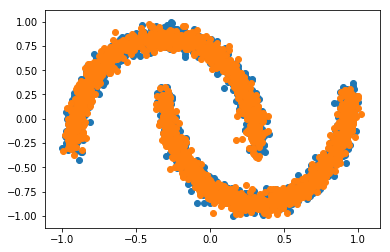

In [7]:
import matplotlib.pyplot as plt
plt.scatter(*X_train.T,label='training')
plt.scatter(*X_test.T,label='test')
plt.legend()

In [ ]:
# set hyperparameters (play with these!)
layer_sizes = [5, 5, n_classes]
n_epochs = 5
batch_size = 200
learning_rate = 0.05

# create network
network = MLP(n_features, layer_sizes)



In [ ]:
# train
network.train(X_train, Y_train, n_epochs, batch_size, learning_rate)

In [ ]:
# test
predicted_posteriors = network.forward(X_test)
# determine class predictions from posteriors by winner-takes-all rule
predicted_classes = ... # your code here
# compute and output the error rate of predicted_classes
error_rate = ... # your code here
print("error rate:", error_rate)